# Modelo de Redes Neuronales 

Se decidió utilizar un modelo de redes neuronales por la facilidad que tienen de manejar grandes volúmenes de datos además de la flexibilidad al momento de recibir distintos tipos de input

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
BASE_PATH = Path().resolve().parent
PATH_DATA = BASE_PATH.joinpath("Hackamine_caso1\Data\Desafio DF")

#C:\Users\ramir\OneDrive\Desktop\Hackamine_caso1\Data\Desafio DF
#tactical_asset_hackamine = pd.read_excel(PATH_DATA.joinpath("tactical_asset_hackamine.xlsx"))
#minecare_data_hackamine = pd.read_csv(PATH_DATA.joinpath("minecare_data_hackamine.csv"))
#dispatch_tum_history_hackamine = pd.read_csv(PATH_DATA.joinpath("dispatch_tum_history_hackamine.csv"))
#sap_work_order_hackamine = pd.read_csv(PATH_DATA.joinpath("sap_work_order_hackamine.csv"))
#catastrophic_failures_hackamine = pd.read_csv(PATH_DATA.joinpath("catastrophic_failures_hackamine.csv"))
reemplazo_historico_componentes = pd.read_excel(PATH_DATA.joinpath("reemplazo_historico_componentes.xlsx"))
#Components_details  = pd.read_excel(PATH_DATA.joinpath("Components_details.xlsx"))
#Mb25_data_hackamine = pd.read_csv(PATH_DATA.joinpath("Mb25_data_hackamine.csv"))


## Se desea predecir la durabilidad de una componente luego de ser cambiada en un equipo

Se filtran los datos considerando las variables relevantes o que podrían afectar la durabilidad de una componente de un equipo. 

In [2]:
df_reemplazo_historico_componentes=reemplazo_historico_componentes[ [ 'MODELO','EQUIPO','FECHA CAMBIO','COMPONENTE','HORAS ACUMULADAS','PCR' ]]
df_reemplazo_historico_componentes=df_reemplazo_historico_componentes.sort_values(by="FECHA CAMBIO")
df_reemplazo_historico_componentes.dropna(inplace=True)
df_reemplazo_historico_componentes= df_reemplazo_historico_componentes.loc[:, df_reemplazo_historico_componentes.columns != 'FECHA CAMBIO']   


Algunas variables son del tipo categorico, por lo que es necesario codificarlas a numeros para luego se ingresadas al modelo de predicción.

In [6]:
import category_encoders as ce # libreria para codificar

# Las variabes son componente, equipo y modelo
###
encoder=ce.OneHotEncoder(cols='COMPONENTE',handle_unknown='return_nan',return_df=True,use_cat_names=True)
encoder1=ce.OneHotEncoder(cols='EQUIPO',handle_unknown='return_nan',return_df=True,use_cat_names=True)
encoder2=ce.OneHotEncoder(cols='MODELO',handle_unknown='return_nan',return_df=True,use_cat_names=True)
##
data_encoded = encoder.fit_transform(df_reemplazo_historico_componentes)
data_encoded = encoder1.fit_transform(data_encoded)
data_encoded = encoder2.fit_transform(data_encoded)
## quitar valores NaN que pueden provocar futuros problemas
data_encoded.dropna(inplace=True)

Escalar los datos:

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()  # unscaled = scaler.inverse_transform(scaled)

## df de variables relevantes para el modelo
data_encoded_x = data_encoded.loc[:, data_encoded.columns != 'HORAS ACUMULADAS'].values
data_encoded_x = scaler.fit_transform(data_encoded_x)
## df de variable a predecir
data_encoded_y = data_encoded[['HORAS ACUMULADAS']].values
data_encoded_y = scaler.fit_transform(data_encoded_y)

Ahora, se divide el conjunto de datos en conjunto entrenamiento y testeo.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_encoded_x,data_encoded_y , test_size=0.33, random_state=42)

## Arquitectura del modelo de predicción

Dada las caracteristicas de los datos y el problema se escoge un perceptron multicapa como modelo predictor. 

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### MLP
### eventualmente los datos podrian comportarse de forma no lineal por lo que se escoge la funcion de activacion relu.
input1 = keras.layers.Input(shape=49)                          # capa de entrada
layer2 = keras.layers.Dense(300, activation='relu')(input1 )   # capa intermedia de 300 neuronas ( no habia tiempo para probar mas valores)
#layer3 = keras.layers.Dense(100, activation='relu')(layer2 )  #
layer4 = keras.layers.Dense(1, activation='relu')(layer2 )     # capa de salida
mlp = keras.models.Model(inputs=input1,outputs=layer4)

mlp.summary()

# Para este problema la funcion a minimizar es mean squared error puesto que se trata de un problema 
# del tipo regresion y la intencion es lograr prediccion lo mas exacta posibles. Se estudian 2 metricas.
mlp.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
dense (Dense)                (None, 300)               15000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 15,301
Trainable params: 15,301
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento del modelo

La cantidad de epocas, asi como el tamaño de batches han sido escogidos rapidamente sin ningun proceso de analisis ni estudio.

In [7]:
mlp.fit(X_train, y_train, batch_size=10, epochs=30, validation_split=0.2,shuffle=True)

Epoch 1/30
26/26 [==============================] - 1s 10ms/step - loss: 0.0166 - mse: 0.0166 - accuracy: 0.0039 - val_loss: 0.0181 - val_mse: 0.0181 - val_accuracy: 0.0000e+00
Epoch 2/30
26/26 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.0099 - accuracy: 0.0039 - val_loss: 0.0176 - val_mse: 0.0176 - val_accuracy: 0.0000e+00
Epoch 3/30
26/26 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086 - accuracy: 0.0039 - val_loss: 0.0191 - val_mse: 0.0191 - val_accuracy: 0.0000e+00
Epoch 4/30
26/26 [==============================] - 0s 3ms/step - loss: 0.0082 - mse: 0.0082 - accuracy: 0.0078 - val_loss: 0.0196 - val_mse: 0.0196 - val_accuracy: 0.0000e+00
Epoch 5/30
26/26 [==============================] - 0s 3ms/step - loss: 0.0073 - mse: 0.0073 - accuracy: 0.0039 - val_loss: 0.0203 - val_mse: 0.0203 - val_accuracy: 0.0000e+00
Epoch 6/30
26/26 [==============================] - 0s 3ms/step - loss: 0.0070 - mse: 0.0070 - accuracy: 0.0039 - val_l

## Guardar el modelo 

Se guarda la arquitectura y pesos del modelo, ya que eventualmente este puede ser implementado en una nube para hacer predicciones de datos en tiempo real.

In [ ]:
# Esto es para guardar la arquitectura del modelo 
#model_json = mlp.to_json()
#with open("Modelos_prediccion\mlp.json", "w") as json_file:
 #   json_file.write(model_json)\n",
# serialize weights to HDF5
#mlp.save_weights("Modelos_prediccion\mlp.h5")

## Testeo del modelo

In [8]:
#mlp.predict()
y_pred = mlp.predict(X_test)
score=np.square(np.subtract(y_test,y_pred)).mean() ## score del perceptron
print('El error del modelo es   {}'.format(score))

El error del modelo es   0.012716125376632414


Ahora se aplica la inversa del escalamiento para estudiar la naturalidad de la variable predicha

In [9]:
## variable predicha
y_pred =  scaler.inverse_transform(y_pred)  ## horas prediccion durabilidad
y_pred_dias= y_pred/24                      ## prediccion en dias
#y_pred_dias=[item for y_pred_dias in y_pred_dias for item in y_pred_dias]
## variable de testeo
y_test =  scaler.inverse_transform(y_test)  ##  horas test durabilidad
y_test_dias= y_test/24                      ## prediccion en dias
#y_test_dias=[item for y_test_dias in y_test_dias for item in y_test_dias]


In [42]:
tabla = np.concatenate((   X_test, y_pred_dias,y_test_dias), axis=1)
columnas=data_encoded.columns.tolist()
columnas.remove("HORAS ACUMULADAS") 
columnas.append('dias_utilizacion_componente')
columnas.append('dias_prediccion_componente')
tabla= pd.DataFrame(tabla,columns=columnas)

In [43]:
tabla

,MODELO_793C,MODELO_793D,MODELO_793F,EQUIPO_CEX20,EQUIPO_CEX23,EQUIPO_CEX05,EQUIPO_CEX24,EQUIPO_CEX28,EQUIPO_CEX31,EQUIPO_CEX29,...,EQUIPO_CEX07,EQUIPO_CEX18,COMPONENTE_DIFERENCIAL,COMPONENTE_MOTOR,COMPONENTE_MANDO FINAL IZQUIERDO,COMPONENTE_MANDO FINAL DERECHO,COMPONENTE_TRANSMISION,PCR,dias_utilizacion_componente,dias_prediccion_componente
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.200000,223.249313,0.083333
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.533333,946.722473,917.000000
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.533333,1317.657715,110.166667
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,361.940948,947.583333
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,588.117004,811.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.533333,796.889587,560.791667
155,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.200000,713.710144,867.375000
156,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.533333,799.843079,888.541667
157,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.200000,366.532227,627.291667


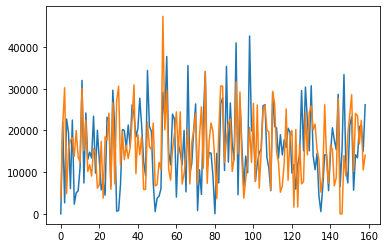

In [15]:
#import matplotlib.pyplot as plt


#plt.plot(y_test)
#plt.plot(y_pred)

